## Steps

1. Select variables you want to cluster: `df = df[["col1", "col2"]]`
2. Convert to array & dtype float: `np_array = df.values.astype("float32", copy = False)`
3. Scale to standard normal:  
> `stscaler = StandardScaler().fit(np_array)
>  np_array = stscaler.transform(np_array)`
4. Create DBSCAN object and fit: `dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)`
5. Extract labels: `labels = dbsc.labels_`
6. Add labels back to original dataframe: 
> `df['labels'] = labels`
7. Explore:
> `df.labels.value_counts()
>  sns.scatterplot(df.col1, df.col2, hue=df.labels)`

Environment Setup

In [1]:
from os import getcwd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

Acquire Data

In [2]:
# get current working directory to be sure I can access the data folder. 
getcwd()

'/Users/maggiegiust/CODEUP/curriculum/misc'

In [3]:
# read customers.csv
df = pd.read_csv('../content/10-anomaly-detection/data/customers.csv')

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.isnull().sum()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.00,440.00,440.00,440.00,440.00,440.00,440.00,440.00
mean,1.32,2.54,"12,000.30","5,796.27","7,951.28","3,071.93","2,881.49","1,524.87"
std,0.47,0.77,"12,647.33","7,380.38","9,503.16","4,854.67","4,767.85","2,820.11"
min,1.00,1.00,3.00,55.00,3.00,25.00,3.00,3.00
25%,1.00,2.00,"3,127.75","1,533.00","2,153.00",742.25,256.75,408.25
50%,1.00,3.00,"8,504.00","3,627.00","4,755.50","1,526.00",816.50,965.50
75%,2.00,3.00,"16,933.75","7,190.25","10,655.75","3,554.25","3,922.00","1,820.25"
max,2.00,3.00,"112,151.00","73,498.00","92,780.00","60,869.00","40,827.00","47,943.00"


Prepare Data

1. Select variables you want to cluster: `df = df[["col1", "col2"]]`
    - we want to cluster all except channel & region
    - these 2 variables are numeric but they don't represent a spatial relationship

In [6]:
# drop channel, region
# df.drop(columns=['Channel', 'Region'], inplace=True)
df = df[['Fresh', 'Frozen', 'Detergents_Paper']]

2. Convert to array dataframe to numpy array and dtype of all values to float, as that is what is required for DBSCAN. 
    - we could use df.values or np.array(df) to convert to an array
    - us astype() to convert to float32 (given these are all integers and we don't intent to go to precision that would require that of float64, we will converse memory and stick with the float32.

In [7]:
type(df.values)
type(np.array(df))

numpy.ndarray

In [8]:
print("df.values:\n object type: {} \n First 5 elements:\n {}".format(type(df.values), df.values[0:5]))
print("df.values:\n object type: {} \n First 5 elements:\n {}".format(type(np.array(df)), np.array(df)[0:5]))

df.values:
 object type: <class 'numpy.ndarray'> 
 First 5 elements:
 [[12669   214  2674]
 [ 7057  1762  3293]
 [ 6353  2405  3516]
 [13265  6404   507]
 [22615  3915  1777]]
df.values:
 object type: <class 'numpy.ndarray'> 
 First 5 elements:
 [[12669   214  2674]
 [ 7057  1762  3293]
 [ 6353  2405  3516]
 [13265  6404   507]
 [22615  3915  1777]]


In [9]:
np_array = df.values.astype("float32",copy=False)
# np_array = np.array(df).astype("float32",copy=False)
np_array[0:5]

array([[12669.,   214.,  2674.],
       [ 7057.,  1762.,  3293.],
       [ 6353.,  2405.,  3516.],
       [13265.,  6404.,   507.],
       [22615.,  3915.,  1777.]], dtype=float32)

3. Scale to standard normal:  
> `stscaler = StandardScaler().fit(np_array)
>  np_array = stscaler.transform(np_array)`

In [10]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:5]

array([[0.11294005, 0.0031063 , 0.0654272 ],
       [0.06289903, 0.02854842, 0.08058985],
       [0.05662161, 0.03911643, 0.08605233],
       [0.11825445, 0.1048419 , 0.01234568],
       [0.20162643, 0.063934  , 0.04345483]], dtype=float32)

4. Create DBSCAN object and fit: `dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)`

In [11]:
dbsc = DBSCAN(eps = .25, min_samples = 50).fit(np_array)

5. Extract labels: `labels = dbsc.labels_`

In [12]:
labels = dbsc.labels_

6. Add labels back to original dataframe: 
> `df['labels'] = labels`

In [13]:
# df = pd.DataFrame(np_array, columns=df.columns)
df['labels'] = labels

In [14]:
df.describe()

,Fresh,Frozen,Detergents_Paper,labels
count,440.00,440.00,440.00,440.00
mean,"12,000.30","3,071.93","2,881.49",-0.02
std,"12,647.33","4,854.67","4,767.85",0.14
min,3.00,25.00,3.00,-1.00
25%,"3,127.75",742.25,256.75,0.00
50%,"8,504.00","1,526.00",816.50,0.00
75%,"16,933.75","3,554.25","3,922.00",0.00
max,"112,151.00","60,869.00","40,827.00",0.00


In [15]:
df.labels.value_counts()

 0    431
-1      9
Name: labels, dtype: int64

7. Explore:
> `df.labels.value_counts()
>  sns.scatterplot(df.col1, df.col2, hue=df.labels)`

In [16]:
df.labels.value_counts()

 0    431
-1      9
Name: labels, dtype: int64

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': '3d'})

ax.scatter(df.Fresh, df.Frozen, df.Detergents_Paper, c=df.labels.astype("int32"), 
            edgecolor='k', alpha=1)

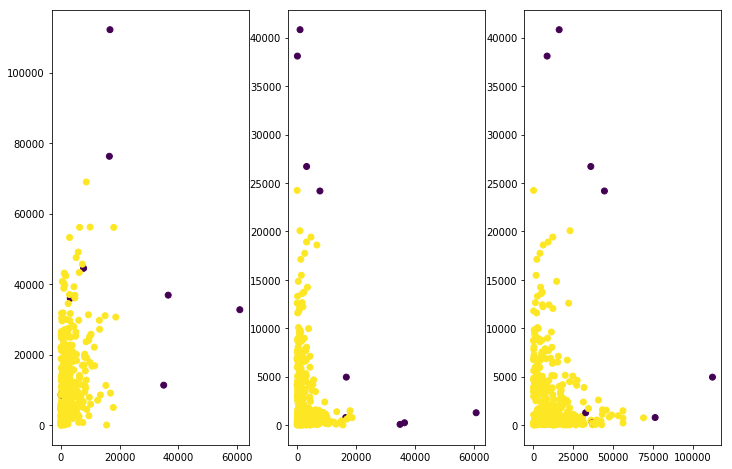

In [27]:
fig, axs = plt.subplots(1,3, figsize = (12,8))

data = df
# for i in range(0,3):
axs[0].scatter(x='Frozen', y='Fresh', data=data, c='labels')
axs[1].scatter(df.Frozen, df.Detergents_Paper, c=df.labels)
axs[2].scatter(df.Fresh, df.Detergents_Paper, c=df.labels)

In [28]:
df[df.labels==-1]

,Fresh,Frozen,Detergents_Paper,labels
47,44466,7782,24171,-1
61,35942,3254,26701,-1
85,16117,1026,40827,-1
93,11314,35009,71,-1
125,76237,16538,778,-1
181,112151,16745,4948,-1
183,36847,36534,239,-1
325,32717,60869,1272,-1
333,8565,131,38102,-1


In [29]:
df.groupby('labels').mean()

,Fresh,Frozen,Detergents_Paper
labels,,,
-1,"41,595.11","19,765.33","15,234.33"
0,"11,382.31","2,723.35","2,623.55"
